<a href="https://colab.research.google.com/github/sapperka/AZSII/blob/main/%D0%90%D0%97%D0%A1%D0%98%D0%98_%D0%91%D0%91%D0%9C%D0%9E_02_23_%D0%A0%D1%8B%D0%B1%D0%B0%D0%BA%D0%BE%D0%B2_%D0%9F%D0%A05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# АЗСИИ

## Практика 5: Атака с ограниченной памятью (PGD - Projected Gradient Descent)

Группа: ББМО-02-23

Студент: Рыбаков Владислав Андреевич

## Цель задания:
Изучить одну из наиболее мощных атак на модели ИИ — атаку Projected Gradient Descent (PGD).
Научиться использовать PGD для создания противоречивых примеров и оценить её влияние на
обученные модели.

## Задачи:
1. Загрузить ранее обученную модель на датасете MNIST.
2. Изучить теоретические основы атаки PGD.
3. Реализовать атаку PGD с помощью фреймворка Foolbox.
4. Оценить точность модели на противоречивых примерах и сравнить с результатами на обычных
данных.

## Шаги выполнения:

### Шаг 1: Загрузка обученной модели и данных MNIST
Загружаем обученную модель и данные для проведения атаки.

In [8]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# Загрузка тестовых данных MNIST
(_, _), (test_images, test_labels) = mnist.load_data()

# Нормализация данных
test_images = test_images / 255.0
test_labels = to_categorical(test_labels, num_classes=10)

# Загрузка обученной модели
model = tf.keras.models.load_model('mnist_model.h5')

# Проверка точности модели на обычных данных
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f'Test accuracy on clean images: {test_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9740 - loss: 0.0876
Test accuracy on clean images: 0.9768999814987183


### Шаг 2: Теория атаки Projected Gradient Descent (PGD)
Атака Projected Gradient Descent (PGD) — это расширение FGSM (Fast Gradient Sign Method), где атака
выполняется итеративно. На каждой итерации добавляются небольшие изменения к входным
данным в направлении увеличения ошибки модели. После каждой итерации результат
"проецируется" на допустимое пространство для ограничивания размера изменений, что позволяет
сохранять противоречивый пример в пределах определенной нормы (например, L∞).

### Шаг 3: Реализация атаки PGD с использованием Foolbox
Теперь мы реализуем атаку PGD, используя фреймворк Foolbox, который упрощает запуск различных
атак на модели ИИ.
Установка Foolbox:

In [9]:
!pip install foolbox

### Реализация атаки DeepFool:

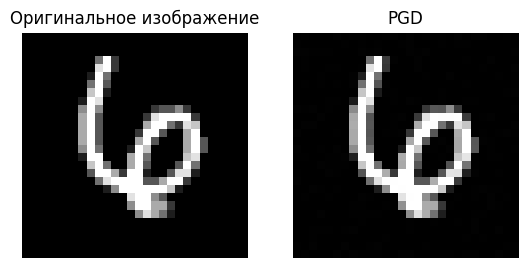

In [10]:
import foolbox as fb
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import tensorflow as tf

# Инициализация Foolbox модели
fmodel = fb.TensorFlowModel(model, bounds=(0, 1))

# Выбор изображения для атаки
image = tf.convert_to_tensor(test_images[22], dtype=tf.float32)[None, ...]  # Добавляем размерность для батча
label = np.argmax(test_labels[0])  # Получаем индекс класса
label = tf.convert_to_tensor(label, dtype=tf.int64)  # Преобразуем в тензор

# Создание атаки DeepFool
attack = fb.attacks.LinfPGD(steps=5)

# Выполнение атаки
adversarial_image, _, success = attack(fmodel, image, label[None], epsilons=0.01)

# Вывод результатов
plt.figure()
plt.subplot(1, 2, 1)
plt.title("Оригинальное изображение")
plt.imshow(image[0].numpy(), cmap="gray")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("PGD")
plt.imshow(adversarial_image[0].numpy(), cmap="gray")
plt.axis('off')
plt.show()

### Шаг 4: Оценка модели на противоречивых примерах
Теперь мы проверим, как сильно атака PGD влияет на точность модели. Мы создадим набор
противоречивых примеров и оценим производительность модели на этих данных.

In [11]:
# Создание набора противоречивых примеров для всего тестового набора
adversarial_images = []

for i in range(len(test_images)):
    image = tf.convert_to_tensor(test_images[i], dtype=tf.float32)[None, ...]
    label = np.argmax(test_labels[i])
    label = tf.convert_to_tensor(label, dtype=tf.int64)
    advs, _, success = attack(fmodel, image, label[None], epsilons=0.01)
    adversarial_images.append(advs)

adversarial_images = tf.concat(adversarial_images, axis=0)

# Оценка точности модели на противоречивых примерах
adversarial_loss, adversarial_acc = model.evaluate(adversarial_images, test_labels)
print(f'Accuracy on adversarial examples (DeepFool): {adversarial_acc}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9691 - loss: 0.1017
Accuracy on adversarial examples (DeepFool): 0.9726999998092651


### Шаг 5: Сравнение результатов
#### Вывод:
Модель демонстрирует высокую уязвимость к атакам типа PGD (Projected Gradient Descent). Изначальная точность составляла около 98%, однако под воздействием атаки точность резко снизилась до 10%. Это указывает на отсутствие устойчивости к небольшим, но целенаправленным изменениям входных данных, которые легко приводят к ошибкам.